# <font color='blue'>Imports </font>

In [5]:
%%time
import pandas as pd
import os
import seaborn as sns
import lightgbm
import optuna
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, log_loss, brier_score_loss, f1_score

Wall time: 1.18 s


In [6]:
%%time
path = "{}\\{}\\{}\\{}\\".format(os.getcwd(), "webscrapping", "matches", "rounds")
filename = "na_merged.csv"
dataset = pd.read_csv('{}{}'.format(path, filename))

Wall time: 833 ms


In [7]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

In [8]:
dataset.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_duelists,DEF_sentinels,DEF_controllers,ATK_Shields,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,172040,1,0,2000,2000,5,5,0,0,0,...,2,1,1,25,100,Ascent,10425,6113,3,0
1,172040,1,5973,1500,2000,4,5,0,0,6,...,2,1,1,25,100,Ascent,10425,6113,3,0
2,172040,1,20664,1000,2000,3,5,0,0,21,...,2,1,1,25,100,Ascent,10425,6113,3,0
3,172040,1,24676,1000,1500,3,4,0,0,25,...,1,1,1,25,75,Ascent,10425,6113,3,0
4,172040,1,26225,1000,1500,3,4,0,0,26,...,1,1,1,25,75,Ascent,10425,6113,3,0


# <font color='blue'> Predict variable </font>

In [9]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [10]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [11]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2000,2000,1,2,1,1,1,2,1,1,...,0,0,0,0,1,0,0,0,0,0
1,1500,2000,1,1,1,1,1,2,1,1,...,0,6,0,0,1,0,0,0,0,0
2,1000,2000,1,1,0,1,1,2,1,1,...,0,21,0,0,1,0,0,0,0,0
3,1000,1500,1,1,0,1,1,1,1,1,...,0,25,0,0,1,0,0,0,0,0
4,1000,1500,1,1,0,1,1,1,1,1,...,0,26,0,0,1,0,0,0,0,0


# <font color='blue'>Parameter tuning </font>

In [12]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [13]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-11-17 14:28:12,917] A new study created in memory with name: no-name-8c72016e-9160-4fb2-a250-adc29fe9021d


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:28:14,743] Trial 0 finished with value: 0.2208466540868305 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 9, 'max_depth': 20, 'learning_rate': 0.0015084913541946446, 'num_leaves': 58, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 0 with value: 0.2208466540868305.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:28:16,697] Trial 1 finished with value: 0.14410266205647437 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 99, 'max_depth': 5, 'learning_rate': 0.014491053288297195, 'num_leaves': 64, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 1 with value: 0.14410266205647437.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:28:18,329] Trial 2 finished with value: 0.12800129195427942 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 98, 'max_depth': 6, 'learning_rate': 0.06995951612284527, 'num_leaves': 28, 'num_threads': 9, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.12800129195427942.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-17 14:28:19,163] Trial 3 finished with value: 0.2418652205881646 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 6, 'max_depth': 1, 'learning_rate': 0.001381731772904484, 'num_leaves': 21, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.12800129195427942.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:28:21,268] Trial 4 finished with value: 0.12649510911669423 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 41, 'max_depth': 8, 'learning_rate': 0.09725802247276207, 'num_leaves': 35, 'num_threads': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-17 14:28:24,415] Trial 5 finished with value: 0.1429739989907492 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 65, 'max_depth': 9, 'learning_rate': 0.01345858452037679, 'num_leaves': 49, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-17 14:28:26,725] Trial 6 finished with value: 0.16680133623265198 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 84, 'max_depth': 19, 'learning_rate': 0.0067852483034359515, 'num_leaves': 44, 'num_threads': 3, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:28:30,074] Trial 7 finished with value: 0.1850787881787867 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 77, 'max_depth': 12, 'learning_rate': 0.004264044737027879, 'num_leaves': 63, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-17 14:28:32,214] Trial 8 finished with value: 0.19922546191537083 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 67, 'max_depth': 15, 'learning_rate': 0.0030113404740217974, 'num_leaves': 56, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-17 14:28:34,521] Trial 9 finished with value: 0.14747720080761767 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 42, 'max_depth': 16, 'learning_rate': 0.011017050201114539, 'num_leaves': 66, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-17 14:28:35,714] Trial 10 finished with value: 0.1327915851921229 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 39, 'max_depth': 10, 'learning_rate': 0.08611928644005602, 'num_leaves': 4, 'num_threads': 7, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:28:37,537] Trial 11 finished with value: 0.1269620803714116 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 27, 'max_depth': 6, 'learning_rate': 0.0941746263139015, 'num_leaves': 32, 'num_threads': 7, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:28:39,323] Trial 12 finished with value: 0.13080745787833561 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 27, 'max_depth': 5, 'learning_rate': 0.03932055250351098, 'num_leaves': 33, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:28:40,390] Trial 13 finished with value: 0.1702853659780395 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 26, 'max_depth': 1, 'learning_rate': 0.032280552530480316, 'num_leaves': 20, 'num_threads': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:28:46,168] Trial 14 finished with value: 0.13025267866027088 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 51, 'max_depth': 7, 'learning_rate': 0.03524000414871417, 'num_leaves': 42, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-17 14:28:47,649] Trial 15 finished with value: 0.12944903225376947 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 22, 'max_depth': 12, 'learning_rate': 0.09784231441271801, 'num_leaves': 8, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-17 14:28:48,816] Trial 16 finished with value: 0.1333062814882781 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 39, 'max_depth': 3, 'learning_rate': 0.05071431311576368, 'num_leaves': 28, 'num_threads': 5, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:28:50,309] Trial 17 finished with value: 0.13667402684832536 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 17, 'max_depth': 9, 'learning_rate': 0.02471653172757652, 'num_leaves': 16, 'num_threads': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-17 14:28:52,101] Trial 18 finished with value: 0.13430570186665655 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 51, 'max_depth': 7, 'learning_rate': 0.023083408238606103, 'num_leaves': 37, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-17 14:28:53,333] Trial 19 finished with value: 0.1312380668745047 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 35, 'max_depth': 3, 'learning_rate': 0.06957569115404107, 'num_leaves': 49, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-17 14:28:55,034] Trial 20 finished with value: 0.12848252502838434 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 63, 'max_depth': 13, 'learning_rate': 0.054458624154739614, 'num_leaves': 33, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:28:56,706] Trial 21 finished with value: 0.12827070530427256 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 98, 'max_depth': 7, 'learning_rate': 0.06546411239551927, 'num_leaves': 26, 'num_threads': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:28:58,497] Trial 22 finished with value: 0.1272796432714268 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 50, 'max_depth': 6, 'learning_rate': 0.090515039940497, 'num_leaves': 27, 'num_threads': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-17 14:28:59,974] Trial 23 finished with value: 0.12807368370174158 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 48, 'max_depth': 4, 'learning_rate': 0.09873285872888422, 'num_leaves': 37, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:01,384] Trial 24 finished with value: 0.1314268568499003 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 32, 'max_depth': 8, 'learning_rate': 0.052457425901454316, 'num_leaves': 11, 'num_threads': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-17 14:29:02,841] Trial 25 finished with value: 0.14111000099909754 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 56, 'max_depth': 10, 'learning_rate': 0.016997238946462784, 'num_leaves': 22, 'num_threads': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:29:04,076] Trial 26 finished with value: 0.17710384253192016 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 14, 'max_depth': 3, 'learning_rate': 0.0070696316556775295, 'num_leaves': 44, 'num_threads': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:29:05,875] Trial 27 finished with value: 0.131805501650538 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 45, 'max_depth': 5, 'learning_rate': 0.04272209462077346, 'num_leaves': 15, 'num_threads': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-17 14:29:11,146] Trial 28 finished with value: 0.1345123606957343 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 57, 'max_depth': 8, 'learning_rate': 0.023529097923208866, 'num_leaves': 32, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.12649510911669423.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:12,751] Trial 29 finished with value: 0.1262184361897258 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 32, 'max_depth': 11, 'learning_rate': 0.09977061043229589, 'num_leaves': 40, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-17 14:29:14,549] Trial 30 finished with value: 0.21109034171874366 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 17, 'max_depth': 14, 'learning_rate': 0.0021420764966735774, 'num_leaves': 53, 'num_threads': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:16,836] Trial 31 finished with value: 0.12696092471223547 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 35, 'max_depth': 11, 'learning_rate': 0.07686466716609315, 'num_leaves': 39, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:18,998] Trial 32 finished with value: 0.22959080202228555 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 31, 'max_depth': 11, 'learning_rate': 0.0010270606800836712, 'num_leaves': 40, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:22,112] Trial 33 finished with value: 0.12725737033960563 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 22, 'max_depth': 11, 'learning_rate': 0.070549446304462, 'num_leaves': 40, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-17 14:29:24,021] Trial 34 finished with value: 0.12729160484325555 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 4, 'max_depth': 9, 'learning_rate': 0.06312181504953332, 'num_leaves': 48, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-17 14:29:26,109] Trial 35 finished with value: 0.12746252252869264 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 35, 'max_depth': 12, 'learning_rate': 0.07731974440875324, 'num_leaves': 30, 'num_threads': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-17 14:29:27,837] Trial 36 finished with value: 0.1289430597296725 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 9, 'max_depth': 17, 'learning_rate': 0.04640388242407887, 'num_leaves': 37, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:29:31,007] Trial 37 finished with value: 0.13108401835132566 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 28, 'max_depth': 13, 'learning_rate': 0.029825982523863235, 'num_leaves': 47, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 29 with value: 0.1262184361897258.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:29:33,329] Trial 38 finished with value: 0.1259579977288299 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 43, 'max_depth': 9, 'learning_rate': 0.09953812156488137, 'num_leaves': 52, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 38 with value: 0.1259579977288299.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:29:35,717] Trial 39 finished with value: 0.1272500840758252 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 43, 'max_depth': 10, 'learning_rate': 0.05835785383461177, 'num_leaves': 58, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 38 with value: 0.1259579977288299.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:29:38,963] Trial 40 finished with value: 0.12655097539191376 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 57, 'max_depth': 9, 'learning_rate': 0.07629829402345692, 'num_leaves': 54, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 38 with value: 0.1259579977288299.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:29:42,323] Trial 41 finished with value: 0.12607959772162378 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 60, 'max_depth': 9, 'learning_rate': 0.07742495564218826, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 38 with value: 0.1259579977288299.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:29:45,736] Trial 42 finished with value: 0.1263191524518899 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 58, 'max_depth': 9, 'learning_rate': 0.07914611585451459, 'num_leaves': 62, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 38 with value: 0.1259579977288299.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:29:51,775] Trial 43 finished with value: 0.1255052513661316 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 72, 'max_depth': 8, 'learning_rate': 0.09969091668750057, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 43 with value: 0.1255052513661316.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:29:57,808] Trial 44 finished with value: 0.12814962495654136 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 70, 'max_depth': 8, 'learning_rate': 0.04345251379109829, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 43 with value: 0.1255052513661316.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:30:03,859] Trial 45 finished with value: 0.12722915268373647 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 77, 'max_depth': 9, 'learning_rate': 0.058009160845141655, 'num_leaves': 62, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 43 with value: 0.1255052513661316.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:30:07,254] Trial 46 finished with value: 0.1259780077044798 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 77, 'max_depth': 10, 'learning_rate': 0.08381417255714253, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 43 with value: 0.1255052513661316.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:30:10,555] Trial 47 finished with value: 0.12538669658578908 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 90, 'max_depth': 14, 'learning_rate': 0.09857171975434761, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 47 with value: 0.12538669658578908.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-17 14:30:16,768] Trial 48 finished with value: 0.12879482381960863 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 88, 'max_depth': 19, 'learning_rate': 0.03686271171705934, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 47 with value: 0.12538669658578908.


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-17 14:30:20,081] Trial 49 finished with value: 0.18740910239611708 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 91, 'max_depth': 15, 'learning_rate': 0.004020634339796354, 'num_leaves': 66, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 47 with value: 0.12538669658578908.


Wall time: 2min 7s


In [14]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.12538669658578908
best hyperparameters: {'bagging_freq': 2, 'min_data_in_leaf': 90, 'max_depth': 14, 'learning_rate': 0.09857171975434761, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}


In [15]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [16]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Wall time: 2.76 s


LGBMClassifier(bagging_freq=2, learning_rate=0.09857171975434761, max_depth=14,
               min_data_in_leaf=90, min_sum_hessian_in_leaf=2, num_leaves=70,
               num_threads=2)

# <font color='blue'>Feature importance </font>

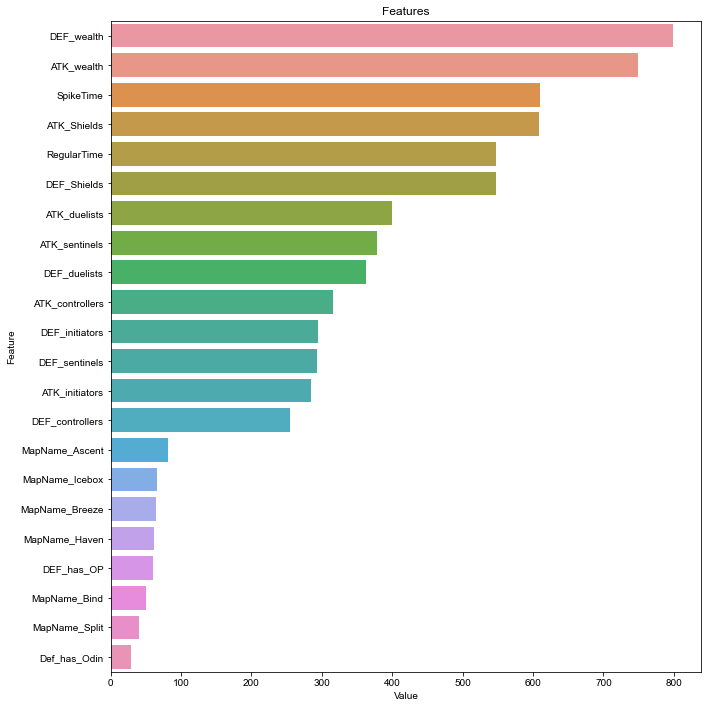

In [17]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
sns.set(font_scale = 1)
plt.title('Features')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

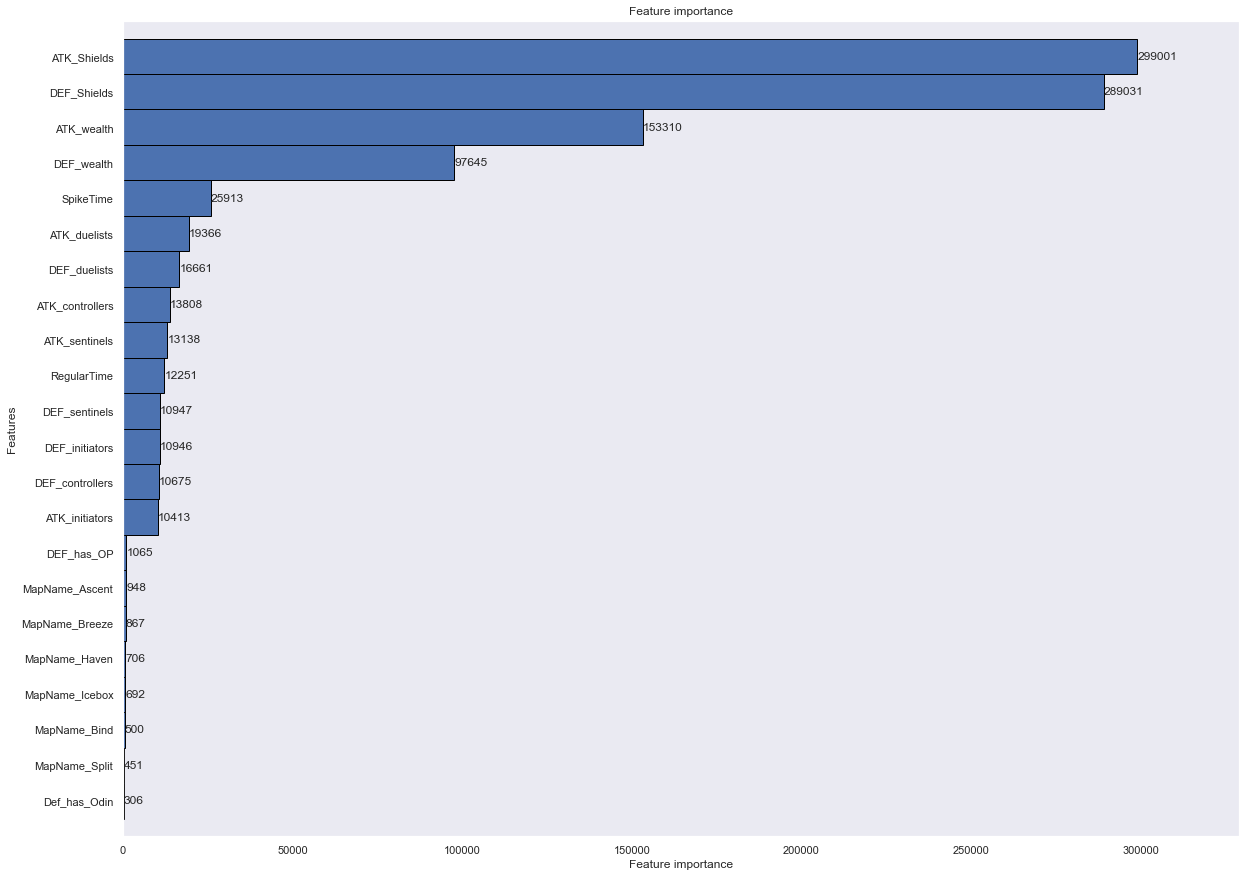

In [18]:
lightgbm.plot_importance(model, height=1, importance_type="gain", precision=0, grid=False, figsize=(20,15), edgecolor='black')

# <font color='blue'>MODEL PRECISION </font>

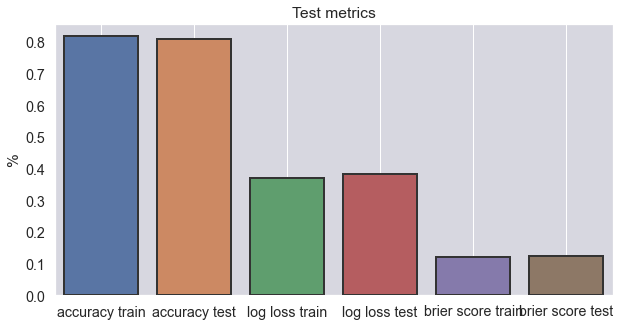

Wall time: 5.52 s


In [19]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [20]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.12538669658578908


# <font color='blue'>REALIBITY CURVE </font>

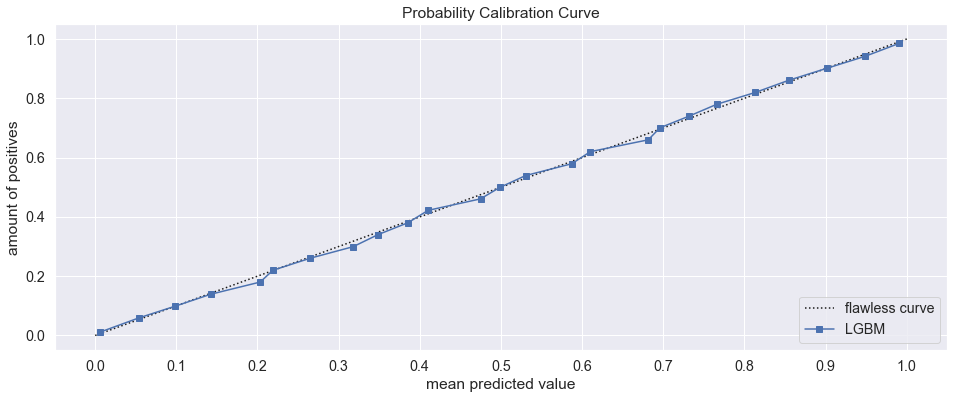

Wall time: 394 ms


Text(0.5, 0, 'mean predicted value')

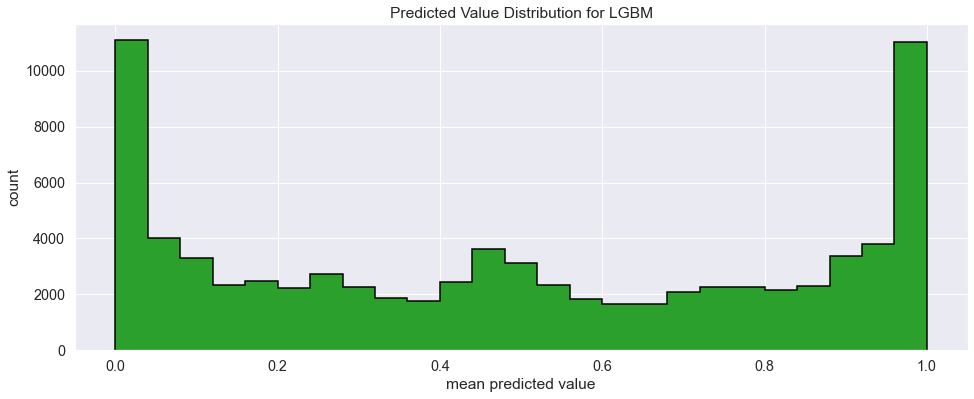

In [21]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

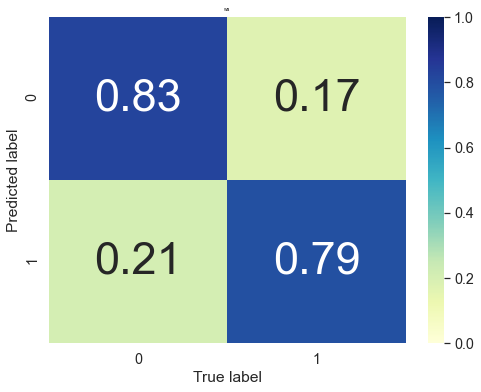

In [22]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [23]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8111350618829752